In [20]:
from __future__ import print_function
import PIL
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# data directory
input = os.getcwd() + "/data"
output = os.getcwd() + "/data/data2.bin"
imageSize = 32
imageDepth = 3
debugEncodedImage = False

# show given image on the window for debug
def showImage(r, g, b):
    temp = []
    for i in range(len(r)):
        temp.append(r[i])
        temp.append(g[i])
        temp.append(b[i])
    show = np.array(temp).reshape(imageSize, imageSize, imageDepth)
    plt.imshow(show, interpolation='nearest')
    plt.show()

# convert to binary bitmap given image and write to law output file
def writeBinaray(outputFile, imagePath, label):
    img = Image.open(imagePath)
    reimg = img.resize((imageSize, imageSize), PIL.Image.ANTIALIAS)
    reimg = (np.array(reimg))

    if reimg.shape != (32, 32, 3):
        print("이미지 다르다")
        return 
    
    r = reimg[:,:,0].flatten()
    g = reimg[:,:,1].flatten()
    b = reimg[:,:,2].flatten()
    label = [label]

    out = np.array(list(label) + list(r) + list(g) + list(b), np.uint8)
    outputFile.write(out.tobytes())

    # if you want to show the encoded image. set up 'debugEncodedImage' flag
    if debugEncodedImage:
        showImage(r, g, b)

subDirs = os.listdir(input)
numberOfClasses = len(input)

try:
    os.remove(output)
except OSError:
    pass

outputFile = open(output, "ab")
label = -1
totalImageCount = 0
labelMap = []

for subDir in subDirs:
    subDirPath = os.path.join(input, subDir)

    # filter not directory
    if not os.path.isdir(subDirPath):
        continue

    imageFileList = os.listdir(subDirPath)
    label += 1

    print("writing %3d images, %s" % (len(imageFileList), subDirPath))
    totalImageCount += len(imageFileList)
    labelMap.append([label, subDir])

    for imageFile in imageFileList:
        imagePath = os.path.join(subDirPath, imageFile)
        writeBinaray(outputFile, imagePath, label)

outputFile.close()
print("Total image count: ", totalImageCount)
print("Succeed, Generate the Binary file")
print("You can find the binary file : ", output)
print("Label MAP: ", labelMap)

import numpy as np
import os
import matplotlib.pyplot as plt

# data directory
input = os.getcwd() + "/data/data2.bin"
imageSize = 32
labelSize = 1
imageDepth = 3
debugEncodedImage = True


# show given image on the window for debug
def showImage(r, g, b):
    temp = []
    for i in range(len(r)):
        temp.append(r[i])
        temp.append(g[i])
        temp.append(b[i])
    show = np.array(temp).reshape(imageSize, imageSize, imageDepth)
    plt.imshow(show, interpolation='nearest')
    plt.show()

def showImageWithData(data, offset):
    eachColorSize = imageSize * imageSize
    offset = labelSize + (labelSize + eachColorSize * 3) * offset

    rgb = []
    for i in range(3):
        color = eachColorSize * i
        rgbData = data[offset + color : offset + color + eachColorSize]
        rgb.append(rgbData)
    
    myData = np.array([rgb[0], rgb[1], rgb[2]])
    myData = myData.reshape(32, 32, 3)

    
    
    return myData, data[offset-1]

def load_batch(path, samples):
    data = np.fromfile(path, dtype='u1')                       
    
    myData = []
    myLabels = []
                       
    for i in range(samples):
        d, l = showImageWithData(data, i)
        myData.append(d)
        myLabels.append(l)

    myData = np.array(myData)
    myLabels = np.array(myLabels)
    
    print(myData.shape)
    
    return myData, myLabels
                       
def load_data():
    dirname = 'data'
    path = os.path.join(dirname, 'data2.bin')
   
    samples = 200                    
    
    x_train = np.empty((samples, 3, 32, 32), dtype='uint8')
    print("")
    y_train = np.empty((samples,), dtype='uint8')
    
    x_train, y_train = load_batch(path, samples)
    
    print("확인 전:", x_train.shape)
    y_train = np.reshape(y_train, (len(y_train), 1))            
    
    return x_train, y_train


import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'eyes_noses_trained_model.h5'

# The data, split between train and test sets: cifar10 없애주기 
x_train, y_train = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')


# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_train /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=200)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

writing 125 images, C:\Users\PSM/data\eyes
이미지 다르다
이미지 다르다
이미지 다르다
이미지 다르다
이미지 다르다
이미지 다르다
writing 124 images, C:\Users\PSM/data\nose
이미지 다르다
이미지 다르다
이미지 다르다
이미지 다르다
Total image count:  249
Succeed, Generate the Binary file
You can find the binary file :  C:\Users\PSM/data/data2.bin
Label MAP:  [[0, 'eyes'], [1, 'nose']]

(200, 32, 32, 3)
확인 전: (200, 32, 32, 3)
x_train shape: (200, 32, 32, 3)
200 train samples
Using real-time data augmentation.
Epoch 1/50
200/200 [==============================] - 42s 210ms/step - loss: 0.7386 - acc: 0.5817
Epoch 2/50
200/200 [==============================] - 38s 190ms/step - loss: 0.5524 - acc: 0.7160
Epoch 3/50
200/200 [==============================] - 38s 192ms/step - loss: 0.4175 - acc: 0.8098
Epoch 4/50
200/200 [==============================] - 38s 191ms/step - loss: 0.3536 - acc: 0.8434
Epoch 5/50
200/200 [==============================] - 38s 191ms/step - loss: 0.3214 - acc: 0.8567
Epoch 6/50
200/200 [==============================] - 38s 192

NameError: name 'x_test' is not defined

30 Prediction :  0
(32, 32, 3)


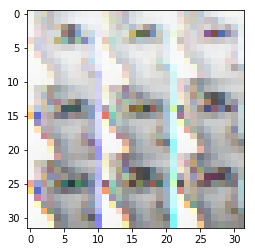

In [25]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import random
from keras.models import load_model

model = load_model('saved_models\eyes_noses_trained_model.h5')
# Get one and predict
r = random.randint(0, 671 - 1)
input_val = x_train[r:r+1]
output_val = model.predict(input_val)

print(r, "Prediction : ", np.argmax(output_val))
# Selected sample showing
print(input_val[0].shape)
plt.imshow(
    input_val[0],
)
plt.show()